# DataRobot API example
### Read the csv dataset from the file system, splitting off a small percentage from the training set to use for scoring predictions.

In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
from pprint import pprint
import os
import datarobot as dr
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

source_data_file = 'data/flight_delay_data.csv'
target = 'DELAY_INDICATOR'

# Read in data from .csv
df_full = pd.read_csv(source_data_file)

# Shuffle the rows
df_full = df_full.sample(frac=1, random_state=0)

# Split 90% for training, 10% for predictions
split = int(df_full.shape[0] * .1)
df = df_full[split:]
df_pred = df_full[:split].copy()

# Drop the target from the prediction dataset
prediction_data = df_pred.drop(target, axis=1)

print('Full data shape:      ',df_full.shape)
print('Training data shape:  ',df.shape)
print('Prediction data shape:',prediction_data.shape)

Full data shape:       (418060, 15)
Training data shape:   (376254, 15)
Prediction data shape: (41806, 14)


### Create a DataRobot project

In [2]:
# Establish client connection
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')

### The 'Out of the Box Autopilot'
#### If we wanted to run autopilot on a dataset and it's features as-is, then we would simply run project.start, which only needs the source data (eg, a csv), the target name, and a project name as parameters.  DataRobot will do the rest in terms of data typing and using informative features.
```
project.start(sourcedata=df, 
              target='DELAY_INDICATOR'
              project_name='Flight delay classification'
```
#### Instead, we'll manually create a project and use a feature list that we'll derive given our domain knowledge of the data.

In [3]:
# # Create a project: and upload the data, set the target, give the project a name
project = dr.Project.create(sourcedata=df, 
                            project_name='Flight Delay API example')

print('project id:  ', project.id)
print('project name:', project.project_name)
print('project.get_status():\n- ', project.get_status())

project id:   5b0203666cd83a3f676fa8ff
project name: Flight Delay API example
project.get_status():
-  {'autopilot_done': False, 'stage_description': 'Ready to set target', 'stage': 'aim'}


### Working with features
#### Start by first retrieving the features from the project object.

In [4]:
# Output the identified project features
features = project.get_features()
sorted([f.name for f in features])

['ACT_AC_TYPE',
 'ARRV_A15_IND',
 'AVOIDABLE_DELAY_IND',
 'CARRIER',
 'DAY_OF_WEEK',
 'DELAY_CODE',
 'DELAY_CODE_DESCRIPTION',
 'DELAY_INDICATOR',
 'DESTINATION',
 'D_O_W_NUM',
 'FLT_DATE',
 'FLT_DATE (Day of Week)',
 'FLT_NBR',
 'HOUR_OF_DPTR',
 'ORIGIN',
 'UNAVOIDABLE_DELAY_IND']

#### We'll transform the flght number feature from numeric to categorical, and create a new feature list omitting features with target leakage, such as other flight delay flags.

In [5]:
# Convert flight number to a categorical variable
new_feature = project.create_type_transform_feature(name='FLT_NBR_CAT', 
                                      parent_name='FLT_NBR', 
                                      variable_type='categoricalInt')
new_feature

Feature(FLT_NBR_CAT)

In [6]:
# Create a new feature list from our subset of features to eliminate target leaks
# new_list = [c for c in df_less_5.columns] + [new_feature.name]
new_list = ['DELAY_INDICATOR', 'ORIGIN', 'DESTINATION', 'CARRIER', 
            'DAY_OF_WEEK', 'HOUR_OF_DPTR', 'ACT_AC_TYPE', new_feature.name]
f_list = project.create_featurelist('No leaks list', new_list)
f_list

Featurelist(No leaks list)

### Kickoff the project

In [7]:
# By calling set_target, we run datarobot
project.set_target(target=target, 
                   mode='auto',
                   worker_count=20,
                   featurelist_id=f_list.id)

Project(Flight Delay API example)

### Get models and blueprints from the leaderboard

In [8]:
# Get the models, which are already ordered by rank from the leaderboard
models = project.get_models()

# Get the best performing model (excluding the blenders, which are typically the top 4 models)
best_model = models[4]
print('Best model from the leaderboard:\n\'%s\'' % best_model.model_type)
print()

# Get the blueprint
blueprint_id = best_model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
print('Best model blueprint preprocessing steps:')
pprint(blueprint.processes)
print()

# Get the model scoring metrics
print('Best model metrics:')
pprint(best_model.metrics)

Best model from the leaderboard:
'eXtreme Gradient Boosted Trees Classifier with Early Stopping (Fast Feature Binning)'

Best model blueprint preprocessing steps:
['Ordinal encoding of categorical variables',
 'Missing Values Imputed',
 'Search for differences',
 'Matrix of word-grams occurrences',
 'Elastic-Net Classifier (L2 / Binomial Deviance)',
 'eXtreme Gradient Boosted Trees Classifier with Early Stopping (Fast Feature '
 'Binning)']

Best model metrics:
{'AUC': {'backtesting': None,
         'backtestingScores': None,
         'crossValidation': None,
         'holdout': None,
         'validation': 0.7039},
 'FVE Binomial': {'backtesting': None,
                  'backtestingScores': None,
                  'crossValidation': None,
                  'holdout': None,
                  'validation': 0.09393},
 'Gini Norm': {'backtesting': None,
               'backtestingScores': None,
               'crossValidation': None,
               'holdout': None,
               'valida

### Make predictions

In [9]:
model = best_model

datasets = project.get_datasets()

# Upload the scoring dataset if not already uploaded, else retrieve it
if (len(datasets) == 0):
    print('Uploading prediction dataset')
    pred_ds = project.upload_dataset(prediction_data)
else:
    print('Retrieving the prediction dataset id')
    for s in datasets:
        if s.name == 'predict.csv':
            pred_ds = s

# Request predictions for the scoring dataset, if it hasn't been already requested
try:                      
    predict_job
except NameError:
    print('Requesitng predictions')
    predict_job = model.request_predictions(pred_ds.id)
    
# Get the predictions results when complete
print('Waiting for prediction results')
predictions = predict_job.get_result_when_complete()
print('- done.  Predictions dataframe:')
print(predictions.head())

# Add a column for the target labels (y_true)
predictions['y_true'] = df_pred[target].astype(int).tolist()
print('\n',predictions.head())

y_true = predictions['y_true'].values
y_pred = predictions['class_1.0'].values

Uploading prediction dataset
Requesitng predictions
Waiting for prediction results
- done.  Predictions dataframe:
   positive_probability  prediction  row_id  class_0.0  class_1.0
0              0.246674         0.0       0   0.753326   0.246674
1              0.169382         0.0       1   0.830618   0.169382
2              0.603128         1.0       2   0.396872   0.603128
3              0.760564         1.0       3   0.239436   0.760564
4              0.252177         0.0       4   0.747823   0.252177

    positive_probability  prediction  row_id  class_0.0  class_1.0  y_true
0              0.246674         0.0       0   0.753326   0.246674       1
1              0.169382         0.0       1   0.830618   0.169382       0
2              0.603128         1.0       2   0.396872   0.603128       1
3              0.760564         1.0       3   0.239436   0.760564       1
4              0.252177         0.0       4   0.747823   0.252177       0


Accuracy: 0.681 (28459/41806)
Log Loss: 0.597
AUC:      0.705


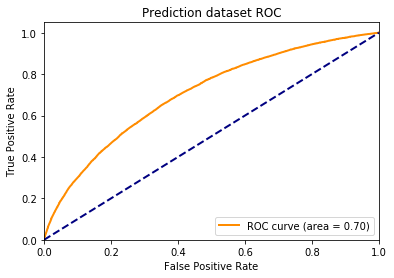

In [10]:
def plot_roc(y_true, y_pred):
    '''
    Plot the ROC curve for a given target and prediction data sets.
    '''
    auc = roc_auc_score(y_true, y_pred)
    print('AUC:      %0.3f' % auc)

    fpr, tpr, _ = roc_curve(y_true, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Prediction dataset ROC' )
    plt.legend(loc="lower right")
    plt.show()
    
# Output some scoring metrics
acc_count = predictions[predictions.prediction == predictions.y_true].shape[0]
accuracy = acc_count*1. / predictions.shape[0]
print('Accuracy: %0.3f (%s/%s)' % (accuracy, acc_count, predictions.shape[0]))
logloss = log_loss(y_true, y_pred)
print('Log Loss: %0.3f'% logloss)

# Plot the ROC curve
plot_roc(y_true, y_pred)